<a href="https://colab.research.google.com/github/ccc-frankfurt/Practical_ML_WS19/blob/master/week2/Regression_Titanic_dataset_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression and the Titanic dataset

Welcome to this week's session where we will explore the Titanic dataset and apply what we have learned about linear and logistic regression and gradient descent methods. 

You can find the Titanic dataset and a corresponding tutorial challenge on Kaggle at https://www.kaggle.com/c/titanic 

In [0]:
!pip install seaborn --upgrade 
!pip install matplotlib --upgrade

Let's first import the libraries we will need:

In [0]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
sns.set()

and load the dataset. Luckily the dataset is available through seaborns load_dataset function, but you can also find it on Kaggle.
Let's print a summary of the dataset.

In [3]:
titanic = sns.load_dataset("titanic")
print(titanic.info())
print(titanic.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB
None
         survived      pclass         age       sibsp       parch        fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.1

## Inspecting the Titanic dataset and preparing it for machine learning

Before we continue with machine learning algorithms, let us take a closer look at the dataset and select suitable features for our regression. 

A good first step is to count the number of entries per feature. 

In [4]:
print("Total count per category")
print(titanic.count())

Total count per category
survived       891
pclass         891
sex            891
age            714
sibsp          891
parch          891
fare           891
embarked       889
class          891
who            891
adult_male     891
deck           203
embark_town    889
alive          891
alone          891
dtype: int64


We can observe that the passenger data has some **incomplete entries** and **some features are missing for certain passengers**. 

In addition some entries are lacking more than others. 

For the overall 891 passangers there is only 2 values missing for the catefories *embarked* and *embark_town*. In other words, we could easily adapt the dataset to include these two features by excluding these two passangers from our list of features. 

Other categories such as *age* and *deck* are much more difficult to leverage. We do not have any means to fill in the missing data and it is a bad idea to throw away the majority of our passenger data if we wanted to use the *deck* feature. The best idea is thus to not consider the *deck* feature in our further analysis.

Let's drop the two passengers with missing *embarked* and *embark_town* entries:

In [5]:
titanic = titanic.dropna(subset=["embarked", "embark_town"])

print(titanic.count())

survived       889
pclass         889
sex            889
age            712
sibsp          889
parch          889
fare           889
embarked       889
class          889
who            889
adult_male     889
deck           201
embark_town    889
alive          889
alone          889
dtype: int64


The next thing we observe is that some features we want to use do not have numerical values but are stored as strings. 

This is the case for the embarked feature that we have just cleaned where passengers are stored into three categories *C, Q, S* depending on whether they have embarked in one of three towns: C = Cherbourg, Q = Queenstown, S = Southampton.   

In [6]:
print(titanic["embarked"])

0      S
1      C
2      S
3      S
4      S
5      Q
6      S
7      S
8      S
9      C
10     S
11     S
12     S
13     S
14     S
15     S
16     Q
17     S
18     S
19     C
20     S
21     S
22     Q
23     S
24     S
25     S
26     C
27     S
28     Q
29     S
      ..
861    S
862    S
863    S
864    S
865    S
866    C
867    S
868    S
869    S
870    S
871    S
872    S
873    S
874    C
875    C
876    S
877    S
878    S
879    C
880    S
881    S
882    S
883    S
884    S
885    Q
886    S
887    S
888    S
889    C
890    Q
Name: embarked, Length: 889, dtype: object


What we often do in machine learning is that we can create a numerical **embedding** where we map the strings to numbers. In our case we can choose a quite simple one  and convert **C, Q, S into 0, 1, 2**.
Luckily pandas offers a function for this named *replace({'string': num})*

In [7]:
# check if already converted because the cell will otherwise
# crash if executed multiple times
if isinstance(titanic["embarked"][0], str):
    titanic["embarked"] = titanic["embarked"].replace({'C': 0, 'Q': 1, 'S': 2})
print(titanic)

     survived  pclass     sex   age  ...  deck  embark_town  alive  alone
0           0       3    male  22.0  ...   NaN  Southampton     no  False
1           1       1  female  38.0  ...     C    Cherbourg    yes  False
2           1       3  female  26.0  ...   NaN  Southampton    yes   True
3           1       1  female  35.0  ...     C  Southampton    yes  False
4           0       3    male  35.0  ...   NaN  Southampton     no   True
5           0       3    male   NaN  ...   NaN   Queenstown     no   True
6           0       1    male  54.0  ...     E  Southampton     no   True
7           0       3    male   2.0  ...   NaN  Southampton     no  False
8           1       3  female  27.0  ...   NaN  Southampton    yes  False
9           1       2  female  14.0  ...   NaN    Cherbourg    yes  False
10          1       3  female   4.0  ...     G  Southampton    yes  False
11          1       1  female  58.0  ...     C  Southampton    yes   True
12          0       3    male  20.0  .

We can also notice that some features exist multiple times in the data frame in multiple repsentations such as *pclass* and *class*, once being encoded numerically and with a string. We will simply select only one of these categories later for our final dataset. 

Let's visuallize  some of the features:

In [8]:
print("\n Female only count")
print(titanic[titanic['sex'].str.match('female')].count())

print("\n Male only count")
print(titanic[titanic['sex'].str.match('male')].count())


 Female only count
survived       312
pclass         312
sex            312
age            259
sibsp          312
parch          312
fare           312
embarked       312
class          312
who            312
adult_male     312
deck            95
embark_town    312
alive          312
alone          312
dtype: int64

 Male only count
survived       577
pclass         577
sex            577
age            453
sibsp          577
parch          577
fare           577
embarked       577
class          577
who            577
adult_male     577
deck           106
embark_town    577
alive          577
alone          577
dtype: int64


We can see that there was almost twice as many males as females on the titanic. 

If we take a look at the age distribution in a box plot with depicted mean and variances, we can see that age is almost evenly distributed, with some outliers in males aged older than 70. 

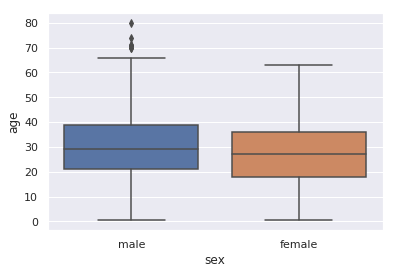

In [9]:
plt.figure()
sns.boxplot(x='sex', y='age', data=titanic)

Let's proceed with taking a visual look at survival rates. Intuitively a good feature for survival rate would be the gender and class of a passenger.

We can display both in a histogram. 

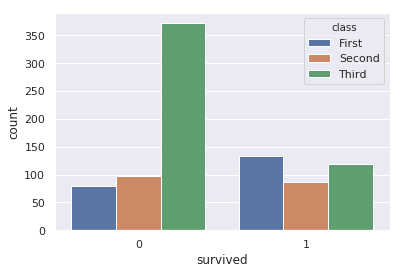

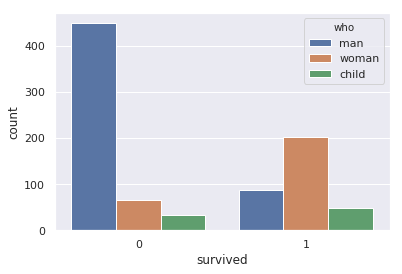

In [10]:
plt.figure()
sns.countplot(x='survived', hue='class', data=titanic)

plt.figure()
sns.countplot(x='survived', hue='who', data=titanic)

We could already build our first hand-engineered simple classifier. From the figures we can observe that survival is very much related to being a female first class passenger.  To provide a better overview we will do this later and compare it with our logistic regression results. 

We are now ready to build our dataset with our selected features and write the code for the logistic regression itself. As a first subset we will select the features *sex, fare, parch, pclass and sibsp (number of siblings or spouses)*. For this we will do a final conversion of the *sex* column and drop one entry as each passenger has an entry for both female and male that are mutually exclusive (0, 1 or 1, 0). We can thus just drop one of the entries entirely.

It's easiest if we concatenate (with *pd.concat*) the selected features into a new pandas data frame and then convert them to numpy matrices. The latter can be achieved by using the *pd.DataFrame.to_numpy(data_frame)* function. 

In order to have a format that is suitable for logistic regression we will also split the labels, in the titanic scenario the *survived* column, into a separate numpy array. 

In [11]:
sex = pd.get_dummies(titanic["sex"], drop_first=True)
fare = titanic["fare"]
parch = titanic["parch"]
pclass = titanic["pclass"]
sibsp = titanic["sibsp"]

features = pd.concat([sex, fare, parch, pclass, sibsp], axis=1)
print(features)

x = pd.DataFrame.to_numpy(features)
y = pd.DataFrame.to_numpy(titanic["survived"])

     male      fare  parch  pclass  sibsp
0       1    7.2500      0       3      1
1       0   71.2833      0       1      1
2       0    7.9250      0       3      0
3       0   53.1000      0       1      1
4       1    8.0500      0       3      0
5       1    8.4583      0       3      0
6       1   51.8625      0       1      0
7       1   21.0750      1       3      3
8       0   11.1333      2       3      0
9       0   30.0708      0       2      1
10      0   16.7000      1       3      1
11      0   26.5500      0       1      0
12      1    8.0500      0       3      0
13      1   31.2750      5       3      1
14      0    7.8542      0       3      0
15      0   16.0000      0       2      0
16      1   29.1250      1       3      4
17      1   13.0000      0       2      0
18      0   18.0000      0       3      1
19      0    7.2250      0       3      0
20      1   26.0000      0       2      0
21      1   13.0000      0       2      0
22      0    8.0292      0       3

## Creation of training and test data splits
The numpy matrices we have just created still lack multiple steps before we can treat them as datasets for logistic regression.
    1. The passanger entries are sorted. This can be problematic if we use stochastic gradient descent methods as some features will be fed first. 
    2. We do not have a train and test split. Creation of this split is crucial as it gives us means to estimate whether our trained model can extrapolate to "unseen" data from the same data distribution, how much it generalizes and how much the model overfits, i.e. "learns by heart". 
    
Let's create a held-out test set by first shuffling the dataset and then extracting 20% of the data. 

We will also have to reshape the labels from vectors to matrices because of shape expectations of numpy's internal matrix multiplication.

In [12]:
perm = np.random.permutation(len(x))

split = 0.8

x_train, x_test = x[perm[:int(split*len(x))]], x[perm[int(split*len(x)):]]
y_train, y_test = y[perm[:int(split*len(y))]], y[perm[int(split*len(y)):]]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(y_train.shape, y_test.shape)

(711, 5) (178, 5) (711,) (178,)
(711, 1) (178, 1)


## Logistic regression

We are ready for the final step. We will now need to implement the missing functionality for the logistic regression itself: 
    1. The sigmoid function
    2. The cross-entropy loss function
    3. The gradient update rule
    4. The training loop
    5. A function to test accuracy on the dataset splits

In [0]:
def sigmoid(z):
    """
    Compute the Sigmoid function
    
    Parameters:
        z (float, np.array): scalar value or numpy array
        
    Returns:
        float, np.array: sigmoid(x)
    """
    
    sig = 1.0 / (1.0 + np.exp(-1.0 * z))
    return sig

In [0]:
def log_loss(y, y_hat):
    """
    Cross-entropy loss function
    
    Parameters:
        y (float, np.array): Labels or targets
        y_hat (float, np.array): Predictions
        
    Returns:
    float: log loss
    """
    loss = -np.mean(y * np.log(y_hat) + (1-y) * np.log(1 - y_hat))
    return loss

In [0]:
def grad_update(grad, lr):
    """
    Gradient descent update rule
    
    Parameters:
        grad (float, np.array): Array of gradients for each weight
        lr (float): learning rate
    """
    return lr * grad

We initialize the weights and bias to zero and set a number of epochs to train and a learning rate to use in the update. Good starting values can be 10000 epochs with a learning rate of 0.005. 

In [33]:
W = np.zeros((x.shape[1], 1))
b = np.zeros((1, 1))

num_epochs = 10000
lr = 0.005

losses = []

for epoch in range(num_epochs):
    z = (x_train @ W) + b
    A = sigmoid(z)
    loss = log_loss(y_train, A)
    losses.append(loss)
    
    dz = A - y_train
    dW = (1/len(x_train)) * (x_train.T @ dz)
    db = (1/len(x_train)) * np.sum(dz)
    
    W = W - grad_update(dW, lr)
    b = b - grad_update(db, lr)
    
    if epoch % 1000 == 0 and epoch > 0:
        print(loss)

0.5619861875751985
0.5337584911782793
0.5160597353064987
0.5043855130944432
0.4963252260186033
0.49051676150865325
0.48615713202906913
0.48275724964997957
0.4800113281791808


We should have seen the loss decreasing over time. For the trained model we can now print the weights and bias values. Unfortunately because logistic regression weights aren't linearly, but multiplicatively combined, it is not straight forward to interpret these weights. 

Don't worry though, in the next weeks we will learn about interpretability and how to inspect models!

In [17]:
print(W, b)

[[-2.06980988]
 [ 0.01379838]
 [ 0.06452956]
 [-0.13028399]
 [-0.29518321]] [[0.77395744]]


Let's visualize our losses. Because we have so many values, it is recommended to take every tenth value only.

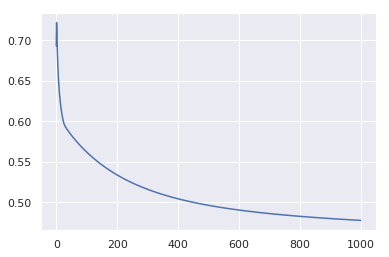

In [18]:
plt.figure()
plt.plot(losses[::10])

While looking at the losses can be meaningful, it doesn't really help our human interpretation of how well we can do on our task of predicting passenger survival. As our model is prediction survival score (like a probability in [0, 1] range.) we can binarize the prediction to yield *survived* if the output value is greater than 0.5. We can calculate this for the entire train and test dataset splits and see how well our model does in terms of accuracy. 

In [0]:
def eval_acc(x, y):
    acc = 0.0
    
    for inp in range(len(x)):
        z = (x[inp] @ W) + b
        A = sigmoid(z)
        
        if (A > 0.5) == y[inp]:
            acc += 1.0
            
    acc /= len(x)
    return acc

In [20]:
train_acc = eval_acc(x_train, y_train)
test_acc = eval_acc(x_test, y_test)

print("Training accuracy: ", train_acc)    
print("Testing accuracy: ", test_acc)  

Training accuracy:  0.8045007032348804
Testing accuracy:  0.7471910112359551


Depending on the exact random split and our gradient descent parameters we can observe training and testing accuracies greater than 80%. If the training accuracy is higher and the test accuracy is low this means that the model is overfitting. If neither of the two accuracies go beyond random chance of 50% (a coin-flip of whether a passenger survived or not) then the model has not trained or the gradient descent got stuck in a local minimum. 

To an extend we can avoid gradient descent (GD) getting stuck in bad local minima or saddle points by making it stochastic (SGD). In the lecture we have encountered a method called mini-batch stochastic gradient descent, that balances the advantages of SGD stochasticity and convergence of GD. 

Let's pick a starting batch size of 100 and see how the training behavior changes. Because we are now doing many more updates than before, it is generally a good idea to lower the learning rate a little or train for an overall lesser amount of epochs. We do not change the number of epochs here but instead halve the learning rate. 

In [27]:
W = np.zeros((x.shape[1], 1))
b = np.zeros((1, 1))
             
num_epochs = 10000
lr = 0.0025
mb_size = 100

losses = []

for epoch in range(num_epochs):
    
    perm = np.random.permutation(len(x_train))
    x_train, y_train = x_train[perm], y_train[perm]
    
    # because we are shuffling the dataset at every point and we do not want
    # updates on a tiny batch size we can neglect the last mini-batch that is 
    # smaller than our mini-batch nice. 
    for mb in range(int(len(x_train) / mb_size)):
        inp = x_train[mb*mb_size:(mb+1)*mb_size]
        target = y_train[mb*mb_size:(mb+1)*mb_size]
    
        z = (inp @ W) + b
        A = sigmoid(z)
        loss = log_loss(target, A)
        losses.append(loss)
    
        dz = A - target
        dW = (1/len(inp)) * (inp.T @ dz)
        db = (1/len(inp)) * np.sum(dz)
    
        W = W - grad_update(dW, lr)
        b = b - grad_update(db, lr)
    
    if epoch % 1000 == 0 and epoch > 0:
        print(loss)

0.5416028730695921
0.5288036596802941
0.5474963528672638
0.5116763035421861
0.46619844630718227
0.49016247369983756
0.4437762510870493
0.5386654965765881
0.46438565117006436


Let's again visualize the losses

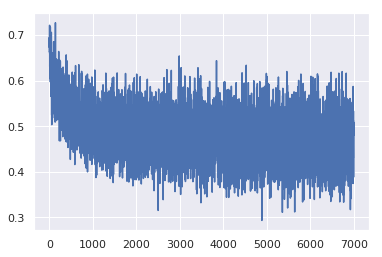

In [28]:
plt.figure()
plt.plot(losses[::10])

In contrast to gradient descent, we observe that the loss no longer behaves deterministically. It is a lot more "jumpy". In fact, if we run the same code multiple times we will also achieve a different result each time. Similarly, the final accuracy we achieve now varies. If we set the parameters right, we can observe the loss initially declining much faster and the final accuracy can be slightly higher. 

In [29]:
train_acc = eval_acc(x_train, y_train)
test_acc = eval_acc(x_test, y_test)

print("Training accuracy: ", train_acc)    
print("Testing accuracy: ", test_acc)  

Training accuracy:  0.8045007032348804
Testing accuracy:  0.7471910112359551


## What now? 

What can we do now? In the next week we will learn about more expressive models like random forests and neural networks that achieve better accuracies and can fit more complex tasks with more than one label. 
For now here's a couple of suggestions what we can do immediately:


    1. Run gradient descent multiple times in a row, do the same for stochastic gradient descent, what do you observe and why? 
    2. How does the model behave if we select a different smaller/large feature set? 
    3. We have learned about more advanced gradient descent techniques such as momentum or adaptive techniques such as Adam. Change the update function and observe what happens.
    4. We have observed earlier that the sex and class feature seem to be highly correlated with survival rate. Can you build a simple classifier by hand, based on the assumption that high passenger class female passengers survive. How does it compare to the logistic regression you have trained?